#### Importing Required Libraries

In [8]:
import pyspark
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#### Creating a Spark Session

In [10]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("CreditRisk") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

#### Reading the Data

In [12]:
df = spark.read.csv("creditrisk.csv", inferSchema = True, header = True, sep=',')

In [13]:
df.select('Property_Area').distinct().show()


+-------------+
|Property_Area|
+-------------+
|        Urban|
|    Semiurban|
|        Rural|
+-------------+



In [14]:
df.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)



In [15]:
df = df.withColumn('Married', when(col('Married')=='No', 0).otherwise(1))
df = df.withColumn('Education', when(col('Education')=='Not Graduate', 0).otherwise(1))
df = df.withColumn('Self_Employed', when(col('Self_Employed')=='No', 0).otherwise(1))
df = df.withColumn('Married', when(col('Married')=='No', 0).otherwise(1))
df = df.withColumn('Education', when(col('Education')=='Not Graduate', 0).otherwise(1))
df = df.withColumn('Loan_Status', when(col('Loan_Status')=='N', 0).otherwise(1))
df = df.withColumn('Self_Employed', when(col('Self_Employed')=='No', 0).otherwise(1))
df = df.na.drop()
df = df.drop('Loan_ID','Gender','Property_Area')

In [16]:
df = df.select(col('Dependents').cast('int').alias('Dependents'),
              'Education',
              'Self_Employed',
              'ApplicantIncome',
              'CoapplicantIncome',
              'LoanAmount',
              'Loan_Amount_Term',
              'Credit_History',
              'Loan_Status')

In [17]:
df.show()
df.printSchema()

+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-----------+
|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Loan_Status|
+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-----------+
|         1|        1|            1|           4583|           1508.0|       128|             360|             1|          0|
|         0|        1|            1|           3000|              0.0|        66|             360|             1|          1|
|         0|        1|            1|           2583|           2358.0|       120|             360|             1|          1|
|         0|        1|            1|           6000|              0.0|       141|             360|             1|          1|
|         2|        1|            1|           5417|           4196.0|       267|             360|             1|     

In [18]:
import pandas as pd
## gather numerical features
data = df.drop("Education","Self_Employed")
numerical_features = [t[0] for t in data.dtypes if t[1] == 'int' or t[1]=='double']
df_numeric = data.select(numerical_features).describe().toPandas().transpose()
df_numeric
data1 = data

<Axes: >

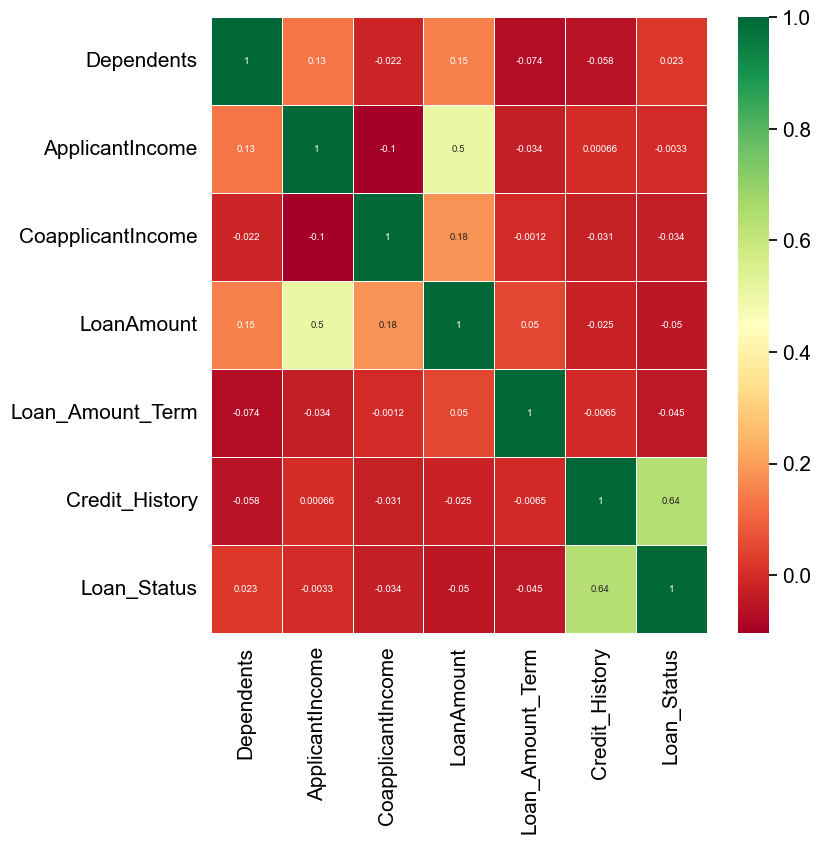

In [19]:
import seaborn as sns; sns.set()
correlation_df = data.select(numerical_features).toPandas().corr()

sns.set(rc={"font.style":"normal",
            "axes.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":False,
            'axes.labelsize':30,
            'figure.figsize':(8.0, 8.0),
            'xtick.labelsize':15,
            'ytick.labelsize':15})
sns.heatmap(correlation_df, annot = True, annot_kws={"size": 7}, cmap="RdYlGn", linewidths=.5)


Before SMOTE:
1    571
0    213
Name: count, dtype: int64

After SMOTE:
1    571
0    571
Name: count, dtype: int64


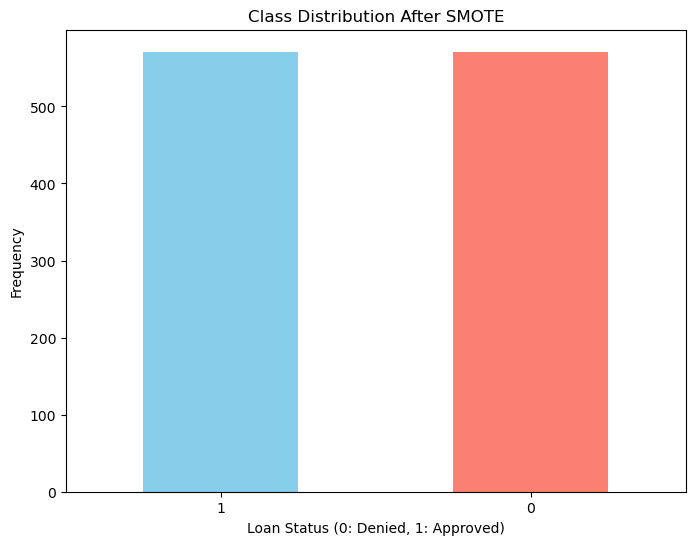

In [3]:
# Import required libraries
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (replace with your actual dataset)
df = pd.read_csv('creditrisk.csv')

# Assuming 'X' are features and 'Loan_Status' is the target variable
X = df.drop(columns=['Loan_Status'])  # Features (all columns except 'Loan_Status')
y = df['Loan_Status']  # Target variable (Loan_Status)

# Encode 'Loan_Status' as it might contain categorical values (e.g., 'approved', 'denied')
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Converts categorical 'Loan_Status' to numeric (e.g., 'approved' -> 1, 'denied' -> 0)

# Handle categorical columns in X (features) by encoding them if necessary
# For label encoding of features (if needed)
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

# Handle missing values (NaN) by using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with the mean value of the column
X = imputer.fit_transform(X)  # Apply the imputer on features

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)  # auto means balance all classes
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check the class distribution before and after SMOTE
print("Before SMOTE:")
print(pd.Series(y_train).value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_train_res).value_counts())

# Plot class distribution after SMOTE
plt.figure(figsize=(8, 6))
pd.Series(y_train_res).value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution After SMOTE')
plt.xlabel('Loan Status (0: Denied, 1: Approved)')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


In [20]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

indexer = StringIndexer(inputCol="Loan_Status", outputCol="categoryIndex")
indexed = indexer.fit(df).transform(df)

In [21]:
features1 = df.columns[:-1]

In [22]:
assembler = VectorAssembler(inputCols=features1, outputCol="features")
data = assembler.transform(indexed)

In [23]:
trainData, testData = data.randomSplit([0.8, 0.2], seed=42)

In [24]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="categoryIndex", featuresCol="features")
lrModel = lr.fit(trainData)

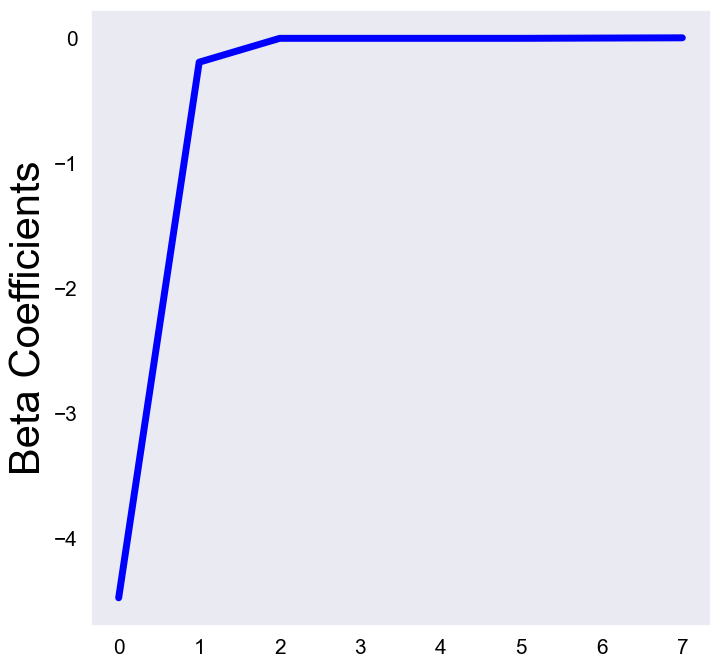

In [25]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta,linewidth = '5',color = 'Blue')
plt.ylabel('Beta Coefficients')
plt.show()

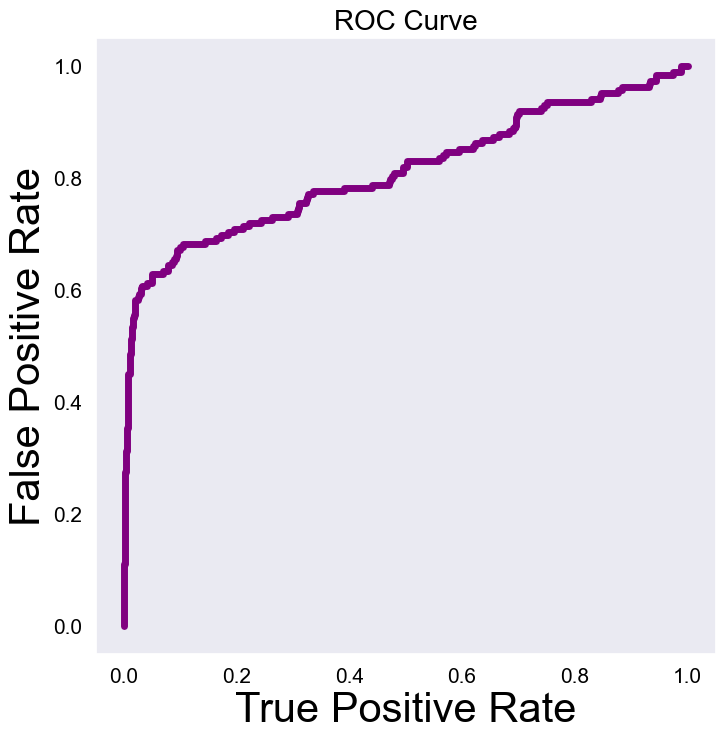

TrainSet areaUnderROC: 0.812307987711214


In [26]:
trainSet = lrModel.summary
roc = trainSet.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'],linewidth = '5',color = 'Purple')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('TrainSet areaUnderROC: ' + str(trainSet.areaUnderROC))

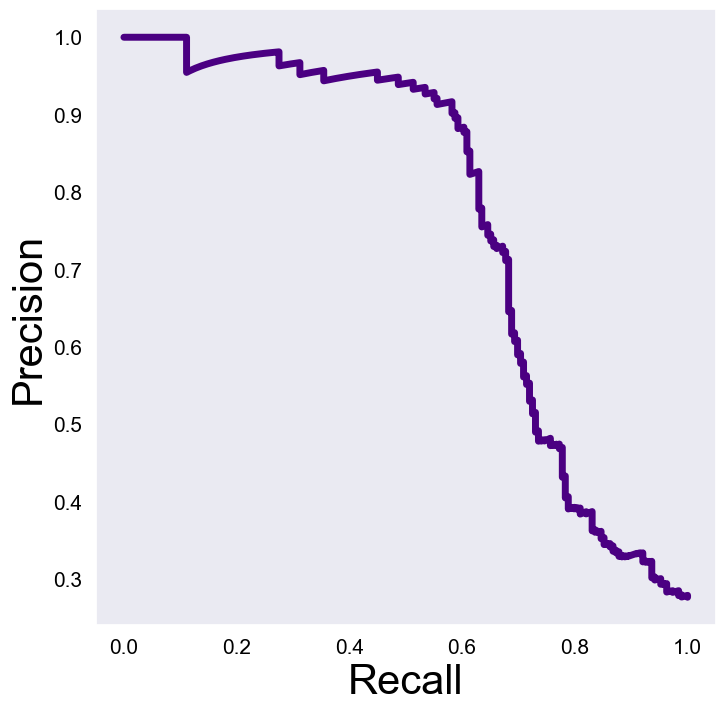

0      0.000000
1      0.005291
2      0.010582
3      0.015873
4      0.021164
         ...   
678    1.000000
679    1.000000
680    1.000000
681    1.000000
682    1.000000
Name: recall, Length: 683, dtype: float64 0      1.000000
1      1.000000
2      1.000000
3      1.000000
4      1.000000
         ...   
678    0.277533
679    0.277126
680    0.276720
681    0.276316
682    0.275912
Name: precision, Length: 683, dtype: float64


In [27]:
pr = trainSet.pr.toPandas()
plt.plot(pr['recall'],pr['precision'],linewidth = '5',color = 'Indigo')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
print(pr['recall'],pr['precision'])

In [28]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix

# Make predictions on the test data
predictions = lrModel.transform(testData)
c = predictions.select('prediction')
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="categoryIndex")
accuracy = evaluator.evaluate(predictions)
print(accuracy)


0.751061249241965


In [29]:
predictions.printSchema()

root
 |-- Dependents: integer (nullable = true)
 |-- Education: integer (nullable = false)
 |-- Self_Employed: integer (nullable = false)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Loan_Status: integer (nullable = false)
 |-- categoryIndex: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [30]:
predictions.select('ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'Credit_History','rawPrediction','prediction', 'probability').show(10)

+---------------+-----------------+----------------+--------------+--------------------+----------+--------------------+
|ApplicantIncome|CoapplicantIncome|Loan_Amount_Term|Credit_History|       rawPrediction|prediction|         probability|
+---------------+-----------------+----------------+--------------+--------------------+----------+--------------------+
|            150|           1800.0|             360|             1|[1.49802602048670...|       0.0|[0.81727987957008...|
|           1300|           3470.0|             180|             1|[2.42673575156939...|       0.0|[0.91884344980301...|
|           1500|           1800.0|             360|             0|[-2.8910742456692...|       1.0|[0.05259656286216...|
|           1700|           2900.0|             360|             0|[-2.7551625308800...|       1.0|[0.05979575111415...|
|           1809|           1868.0|             360|             1|[1.62141881074199...|       0.0|[0.83499070821538...|
|           1836|          33837

In [31]:
## Random Forest Classifier
from pyspark.ml.classification import RandomForestClassifier
# Creating RandomForest model.
rf = RandomForestClassifier(labelCol='categoryIndex', featuresCol='features')
## train the model
rfModel = rf.fit(trainData)
## make predictions
predictions = rfModel.transform(testData)
predictions.printSchema()

root
 |-- Dependents: integer (nullable = true)
 |-- Education: integer (nullable = false)
 |-- Self_Employed: integer (nullable = false)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Loan_Status: integer (nullable = false)
 |-- categoryIndex: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



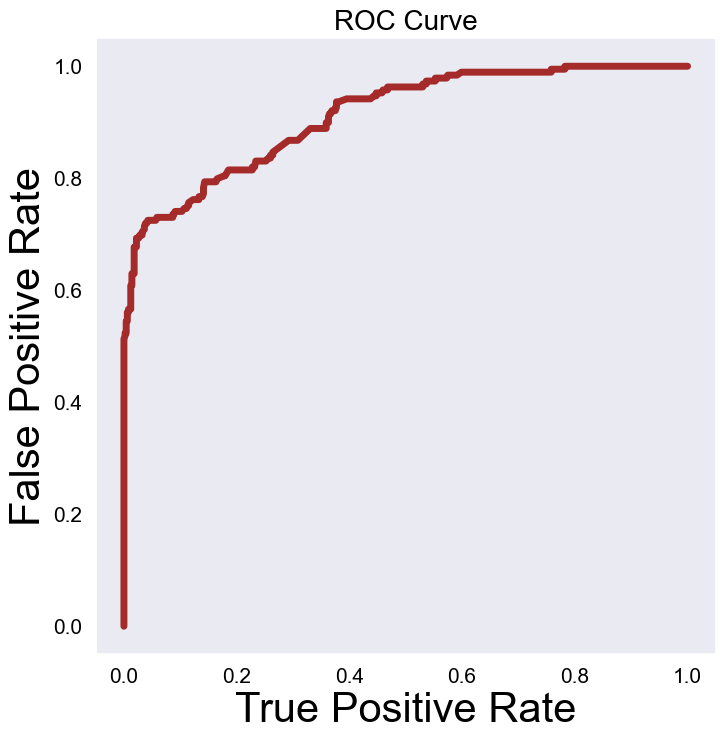

TrainSet areaUnderROC: 0.9123837258917882


In [32]:
trainSet = rfModel.summary
roc = trainSet.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'],linewidth = '5',color = 'Brown')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('TrainSet areaUnderROC: ' + str(trainSet.areaUnderROC))

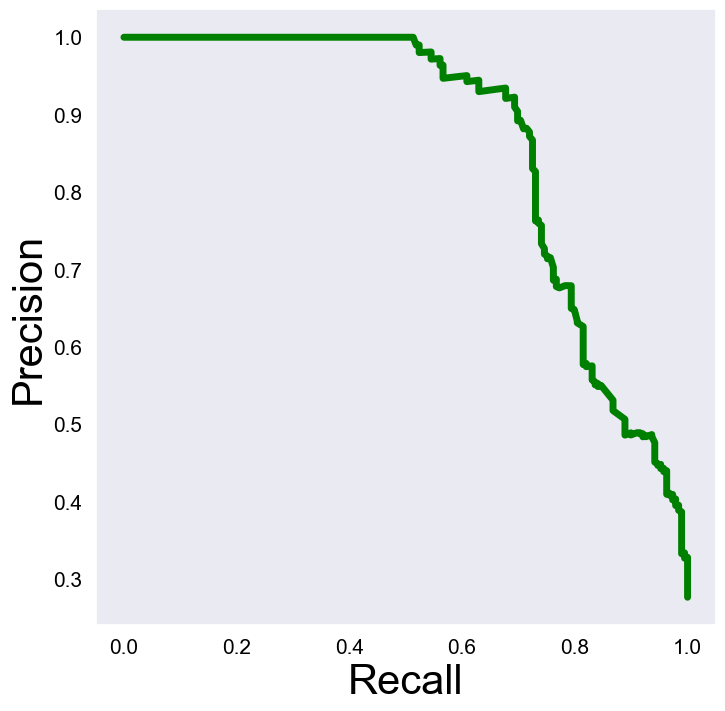

In [33]:
pr = trainSet.pr.toPandas()
plt.plot(pr['recall'],pr['precision'],linewidth = '5',color = 'Green')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [34]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="categoryIndex")
accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.8195876288659795


In [35]:
rfPredictions = predictions.select('Loan_Amount_Term', 'Credit_History','rawPrediction','prediction', 'probability').show(10)

+----------------+--------------+--------------------+----------+--------------------+
|Loan_Amount_Term|Credit_History|       rawPrediction|prediction|         probability|
+----------------+--------------+--------------------+----------+--------------------+
|             360|             1|[16.1425715905084...|       0.0|[0.80712857952542...|
|             180|             1|[15.5716199097335...|       0.0|[0.77858099548667...|
|             360|             0|[2.18141713771026...|       1.0|[0.10907085688551...|
|             360|             0|[4.68141713771026...|       1.0|[0.23407085688551...|
|             360|             1|[17.9571085461504...|       0.0|[0.89785542730752...|
|             360|             1|[13.0844389773904...|       0.0|[0.65422194886952...|
|             360|             1|[17.7252267636250...|       0.0|[0.88626133818125...|
|             360|             1|[17.1595047419114...|       0.0|[0.85797523709557...|
|             360|             1|[16.802619

In [36]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from sklearn.neighbors import KNeighborsClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.getOrCreate()

In [37]:
# Load the dataset into a DataFrame
credit_data = data1.toPandas()
feature_cols = data1.columns[:-1] 
label_col = "Loan_Status"
X = credit_data[feature_cols]
y = credit_data[label_col]
data

DataFrame[Dependents: int, Education: int, Self_Employed: int, ApplicantIncome: int, CoapplicantIncome: double, LoanAmount: int, Loan_Amount_Term: int, Credit_History: int, Loan_Status: int, categoryIndex: double, features: vector]

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
k=3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [40]:
y_pred = knn.predict(X_test)

In [41]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.673469387755102
Precision: 0.746268656716418
Recall: 0.8379888268156425


<BarContainer object of 3 artists>

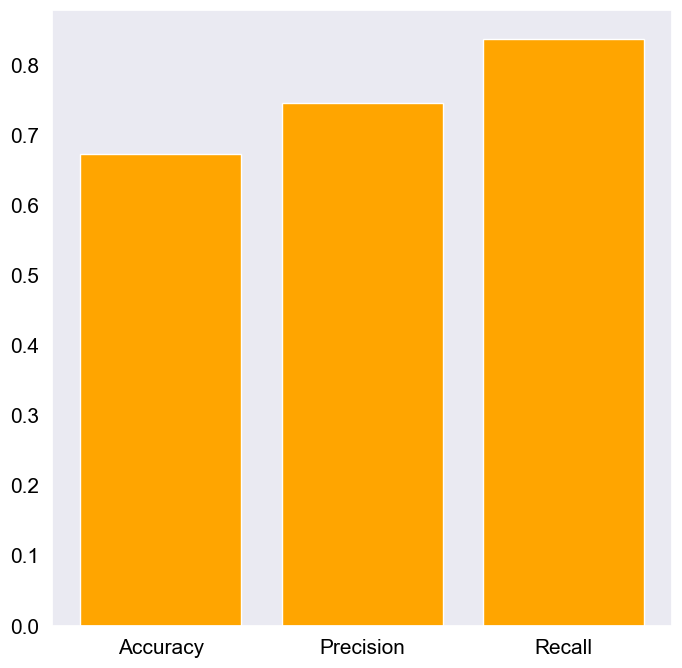

In [42]:
class1 = ["Accuracy","Precision","Recall"]
acc = [accuracy,precision,recall]
plt.bar(class1,acc,color='orange')

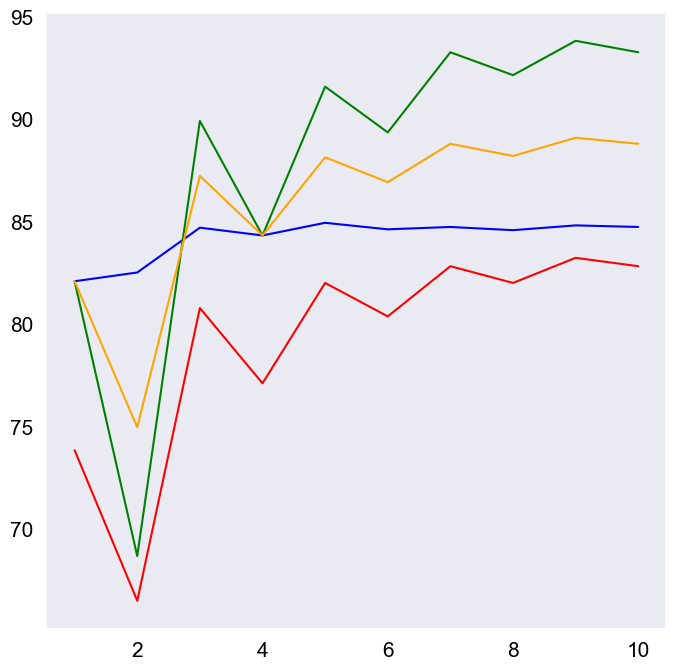

In [43]:
from sklearn.preprocessing import StandardScaler
a = []
p = []
r = []
f = []
xc =[1,2,3,4,5,6,7,8,9,10]
for i in range(1,11):
    st_x = StandardScaler()
    x_train2 = st_x.fit_transform(X_train)
    x_test2 = st_x.fit_transform(X_test)
    knn = KNeighborsClassifier(n_neighbors = i,metric = 'euclidean',p=2)
    knn.fit(x_train2,y_train)
    y_predict = knn.predict(x_test2)
    k1 = accuracy_score(y_test,y_predict)*100
    k2 = recall_score(y_test,y_predict)*100
    k3 = precision_score(y_test,y_predict)*100
    k4 = f1_score(y_test,y_predict)*100
    a.append(k1)
    p.append(k3)
    r.append(k2)
    f.append(k4)
plt.plot(xc,a,color='red')
plt.plot(xc,p,color='blue')
plt.plot(xc,r,color='green')
plt.plot(xc,f,color='orange')

In [44]:
SVM Stand alone classifier

SyntaxError: invalid syntax (2841476258.py, line 1)

In [45]:
from pyspark.ml.classification import LinearSVC

# Assuming the dataset is already loaded into `data` and processed into features and label
# Split the dataset into training and testing sets
trainData, testData = data.randomSplit([0.8, 0.2], seed=42)

# Initialize the Linear Support Vector Machine model
svm = LinearSVC(labelCol="categoryIndex", featuresCol="features", maxIter=100)

# Train the SVM model
svmModel = svm.fit(trainData)

# Make predictions on the test data
predictions = svmModel.transform(testData)

# Display required columns from the predictions
predictions.select(
    'ApplicantIncome', 
    'CoapplicantIncome', 
    'Loan_Amount_Term', 
    'Credit_History',
    'rawPrediction', 
    'prediction'
).show(10)


+---------------+-----------------+----------------+--------------+--------------------+----------+
|ApplicantIncome|CoapplicantIncome|Loan_Amount_Term|Credit_History|       rawPrediction|prediction|
+---------------+-----------------+----------------+--------------+--------------------+----------+
|            150|           1800.0|             360|             1|[0.99999999733800...|       0.0|
|           1300|           3470.0|             180|             1|[1.00000012816687...|       0.0|
|           1500|           1800.0|             360|             0|[-1.0001992710801...|       1.0|
|           1700|           2900.0|             360|             0|[-1.0001992711087...|       1.0|
|           1809|           1868.0|             360|             1|[0.99999999710049...|       0.0|
|           1836|          33837.0|             360|             1|[0.99999999709662...|       0.0|
|           1937|           1152.0|             360|             1|[0.99999999708216...|       0.0|


In [47]:
from pyspark.ml.classification import LinearSVC
from pyspark.sql.functions import col
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Assuming the dataset is already loaded into `data` and processed into features and label
# Split the dataset into training and testing sets
trainData, testData = data.randomSplit([0.8, 0.2], seed=42)

# Initialize the Linear Support Vector Machine model
svm = LinearSVC(labelCol="categoryIndex", featuresCol="features", maxIter=100)

# Train the SVM model
svmModel = svm.fit(trainData)

# Make predictions on the test data
predictions = svmModel.transform(testData)

# Extract predictions and labels
predictions_and_labels = predictions.select(col('prediction').alias('pred'), col('categoryIndex').alias('label')).toPandas()

# Compute metrics
accuracy = accuracy_score(predictions_and_labels['label'], predictions_and_labels['pred'])
precision = precision_score(predictions_and_labels['label'], predictions_and_labels['pred'])
recall = recall_score(predictions_and_labels['label'], predictions_and_labels['pred'])
conf_matrix = confusion_matrix(predictions_and_labels['label'], predictions_and_labels['pred'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("Confusion Matrix:")
print(conf_matrix)




Accuracy: 0.8549618320610687
Precision: 1.0
Recall: 0.4411764705882353
Confusion Matrix:
[[97  0]
 [19 15]]


In [49]:
# Plotting the metrics
metrics = ['Accuracy', 'Precision', 'Recall']
values = [accuracy, precision, recall]



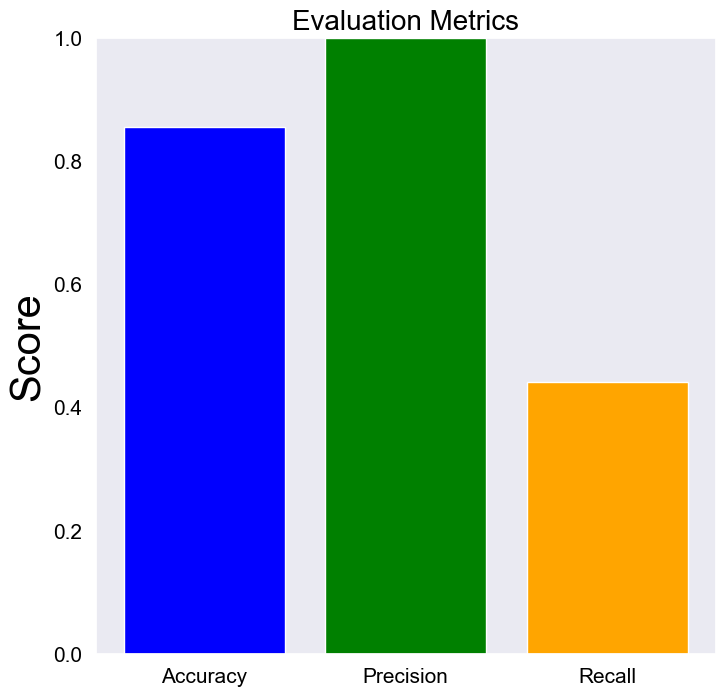

In [51]:
plt.bar(metrics, values, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.show()



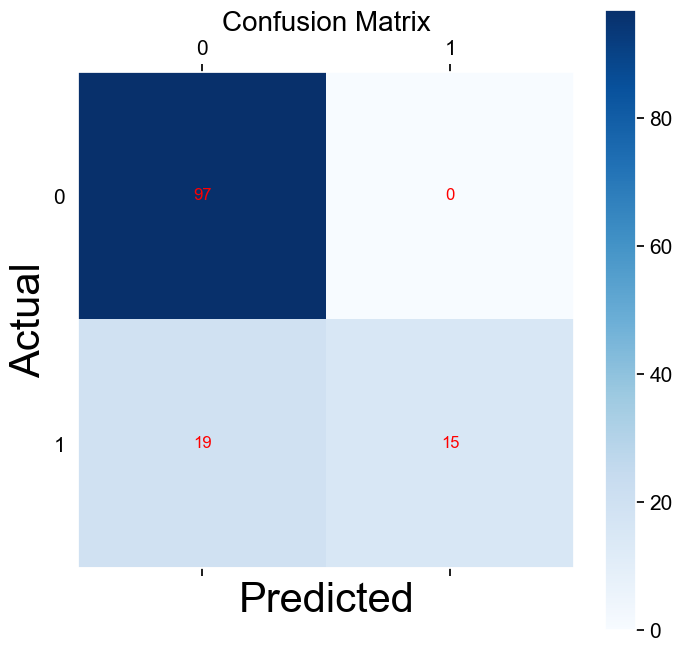

In [53]:
# Confusion Matrix Plot
plt.matshow(conf_matrix, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(range(2), ['0', '1'])  # Assuming binary classification
plt.yticks(range(2), ['0', '1'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='red')
plt.show()

In [55]:
# Load the dataset into a DataFrame
credit_data = data1.toPandas()
feature_cols = data1.columns[:-1] 
label_col = "Loan_Status"
X = credit_data[feature_cols]
y = credit_data[label_col]
data

DataFrame[Dependents: int, Education: int, Self_Employed: int, ApplicantIncome: int, CoapplicantIncome: double, LoanAmount: int, Loan_Amount_Term: int, Credit_History: int, Loan_Status: int, categoryIndex: double, features: vector]

In [57]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming your data is loaded into a pandas DataFrame `df`
# You can create your X and y from your DataFrame
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Initialize and train Naive Bayes classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')  # For binary classification
f1 = f1_score(y_test, y_pred, average='binary')  # For binary classification

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.8448979591836735
Precision: 0.8439024390243902
Recall: 0.9664804469273743
F1 Score: 0.9010416666666666


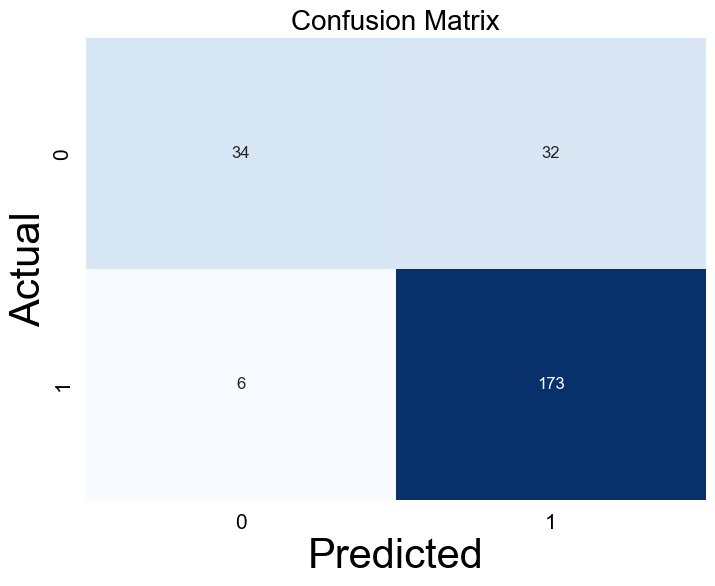

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are already defined
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix with Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


C:\Users\chetan\AppData\Local\Temp\ipykernel_46132\109754955.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette='Blues')


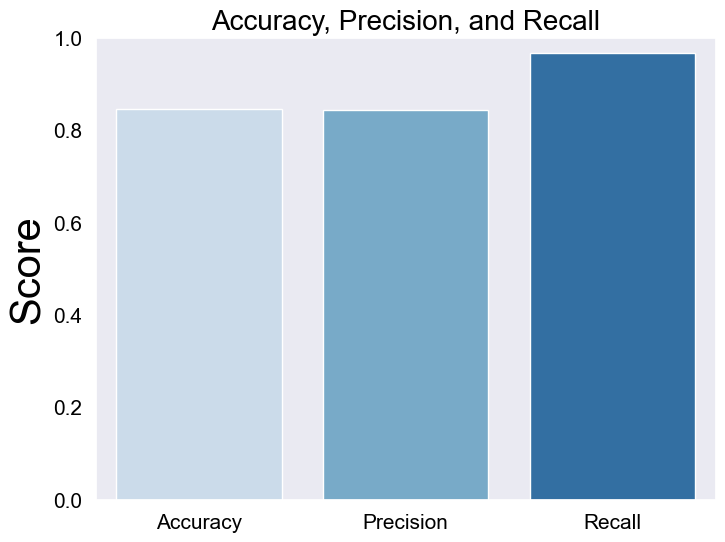

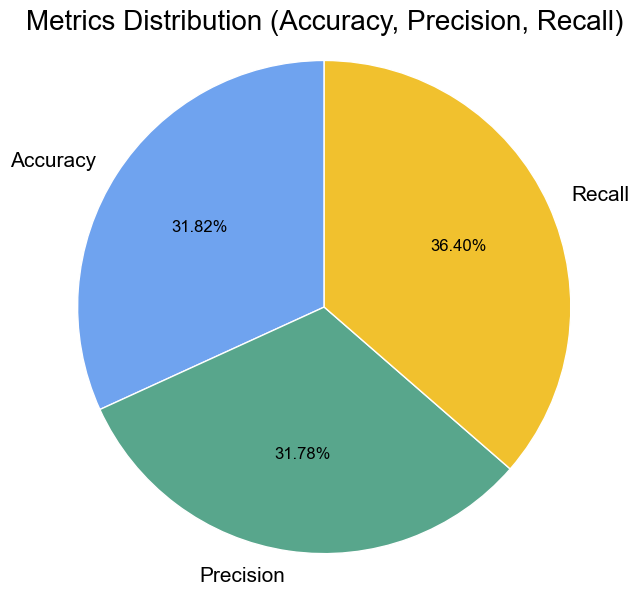

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Assuming you have y_test and y_pred
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # Adjust for multi-class if needed
recall = recall_score(y_test, y_pred, average='binary')  # Adjust for multi-class if needed

# Create a DataFrame for easy plotting
metrics = ['Accuracy', 'Precision', 'Recall']
scores = [accuracy, precision, recall]

# Bar plot for Accuracy, Precision, and Recall
plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=scores, palette='Blues')
plt.title('Accuracy, Precision, and Recall')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Alternatively, a pie chart to represent the metrics visually
plt.figure(figsize=(7, 7))
plt.pie(scores, labels=metrics, autopct='%1.2f%%', colors=['#6fa3ef', '#58a68c', '#f1c12e'], startangle=90)
plt.title('Metrics Distribution (Accuracy, Precision, Recall)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [67]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

# Drop the 'features' column if it exists
data = data.drop("features")

# Create feature vector using VectorAssembler
assembler = VectorAssembler(inputCols=['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'Credit_History'], 
                            outputCol='features')

# Transform the data to create the feature vector
data = assembler.transform(data)

# Split the dataset into training and testing sets
trainData, testData = data.randomSplit([0.8, 0.2], seed=42)

# Initialize the Naive Bayes model
nb = NaiveBayes(labelCol="categoryIndex", featuresCol="features", modelType="multinomial")

# Train the Naive Bayes model
nbModel = nb.fit(trainData)

# Make predictions on the test data
predictions = nbModel.transform(testData)

# Display required columns from the predictions
predictions.select(
    'ApplicantIncome', 
    'CoapplicantIncome', 
    'Loan_Amount_Term', 
    'Credit_History',
    'rawPrediction', 
    'prediction'
).show(10)


+---------------+-----------------+----------------+--------------+--------------------+----------+
|ApplicantIncome|CoapplicantIncome|Loan_Amount_Term|Credit_History|       rawPrediction|prediction|
+---------------+-----------------+----------------+--------------+--------------------+----------+
|            150|           1800.0|             360|             1|[-3934.7356503342...|       1.0|
|           1300|           3470.0|             180|             1|[-6317.8281785368...|       1.0|
|           1500|           1800.0|             360|             0|[-4333.6194731226...|       1.0|
|           1700|           2900.0|             360|             0|[-6095.7540721945...|       1.0|
|           1809|           1868.0|             360|             1|[-4541.0317307475...|       1.0|
|           1836|          33837.0|             360|             1|[-54005.953395161...|       1.0|
|           1937|           1152.0|             360|             1|[-3472.0257442114...|       1.0|


In [69]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

# Drop the 'features' column if it exists (no axis argument)
if "features" in data.columns:
    data = data.drop("features")

# Create feature vector using VectorAssembler
assembler = VectorAssembler(inputCols=['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'Credit_History'], 
                            outputCol='features')

# Transform the data to create the feature vector
data = assembler.transform(data)

# Split the dataset into training and testing sets
trainData, testData = data.randomSplit([0.8, 0.2], seed=42)

# Initialize the Naive Bayes model
nb = NaiveBayes(labelCol="categoryIndex", featuresCol="features", modelType="multinomial")

# Train the Naive Bayes model
nbModel = nb.fit(trainData)

# Make predictions on the test data
predictions = nbModel.transform(testData)

# Display required columns from the predictions
predictions.select(
    'ApplicantIncome', 
    'CoapplicantIncome', 
    'Loan_Amount_Term', 
    'Credit_History',
    'rawPrediction', 
    'prediction'
).show(10)


+---------------+-----------------+----------------+--------------+--------------------+----------+
|ApplicantIncome|CoapplicantIncome|Loan_Amount_Term|Credit_History|       rawPrediction|prediction|
+---------------+-----------------+----------------+--------------+--------------------+----------+
|            150|           1800.0|             360|             1|[-3934.7356503342...|       1.0|
|           1300|           3470.0|             180|             1|[-6317.8281785368...|       1.0|
|           1500|           1800.0|             360|             0|[-4333.6194731226...|       1.0|
|           1700|           2900.0|             360|             0|[-6095.7540721945...|       1.0|
|           1809|           1868.0|             360|             1|[-4541.0317307475...|       1.0|
|           1836|          33837.0|             360|             1|[-54005.953395161...|       1.0|
|           1937|           1152.0|             360|             1|[-3472.0257442114...|       1.0|


Accuracy: 0.8396946564885496
Precision: 0.8460559796437659
Recall: 0.8396946564885496


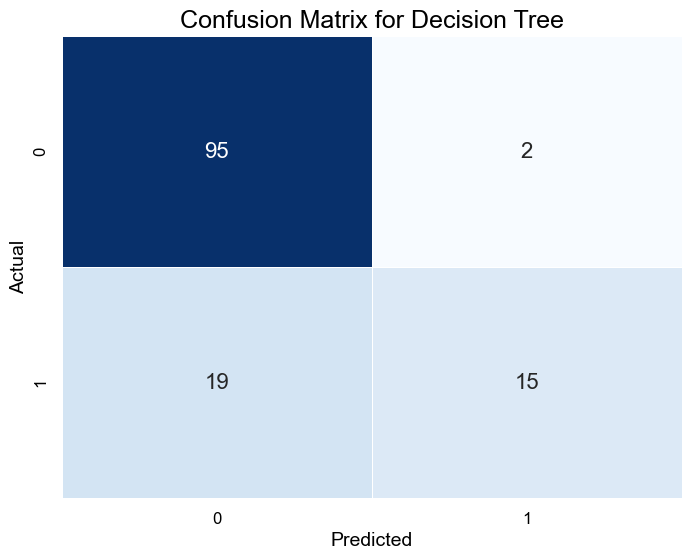

C:\Users\chetan\AppData\Local\Temp\ipykernel_46132\3979321172.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette='Blues_d')


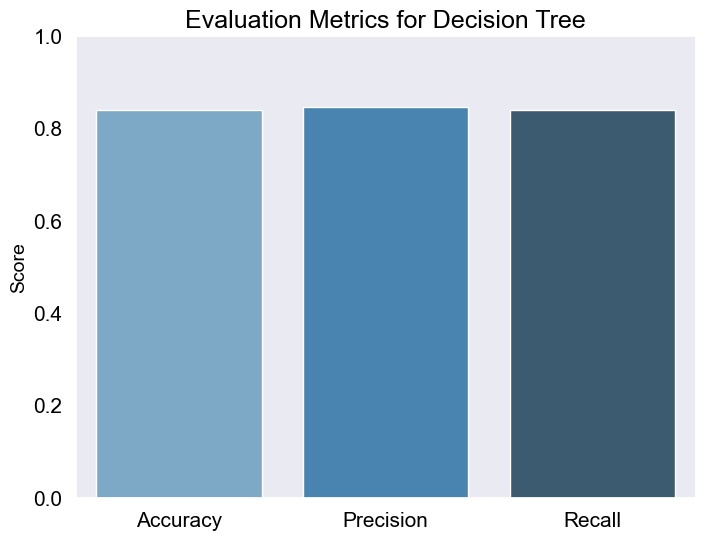

In [71]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the 'features' column if it exists (no axis argument)
if "features" in data.columns:
    data = data.drop("features")

# Create feature vector using VectorAssembler
assembler = VectorAssembler(inputCols=['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'Credit_History'], 
                            outputCol='features')

# Transform the data to create the feature vector
data = assembler.transform(data)

# Split the dataset into training and testing sets
trainData, testData = data.randomSplit([0.8, 0.2], seed=42)

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(labelCol="categoryIndex", featuresCol="features")

# Train the Decision Tree model
dtModel = dt.fit(trainData)

# Make predictions on the test data
predictions = dtModel.transform(testData)

# Evaluate the model using MulticlassClassificationEvaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="categoryIndex", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")




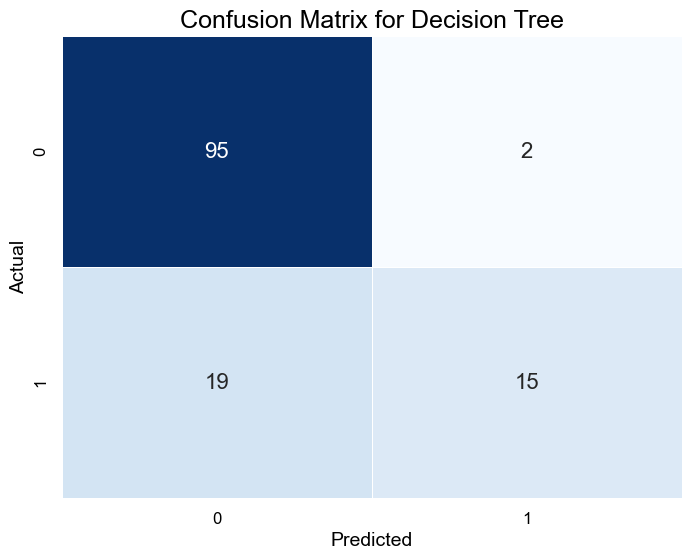

C:\Users\chetan\AppData\Local\Temp\ipykernel_46132\1314584462.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette='Blues_d')


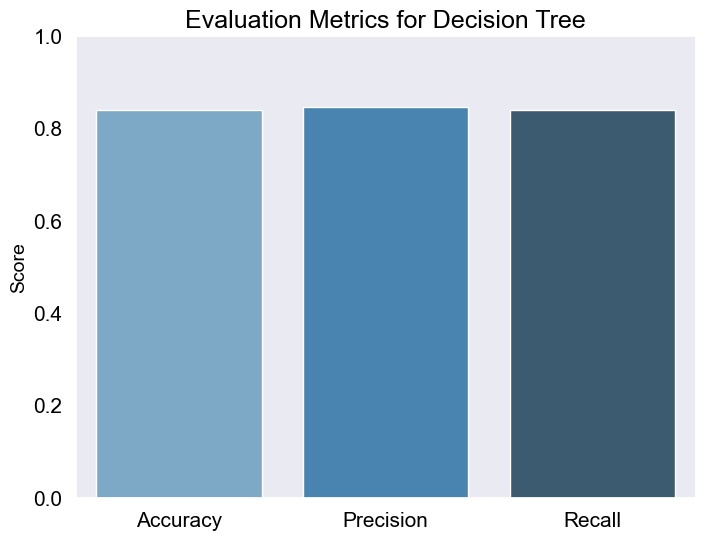

In [73]:
# Convert the predictions DataFrame to Pandas for confusion matrix
predictions_pd = predictions.select("categoryIndex", "prediction").toPandas()

# Confusion Matrix
conf_matrix = confusion_matrix(predictions_pd['categoryIndex'], predictions_pd['prediction'])

# Plotting Confusion Matrix with Black Color Scheme
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16}, linewidths=0.5)
plt.title('Confusion Matrix for Decision Tree', fontsize=18)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



C:\Users\chetan\AppData\Local\Temp\ipykernel_46132\1654806863.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette='Blues_d')


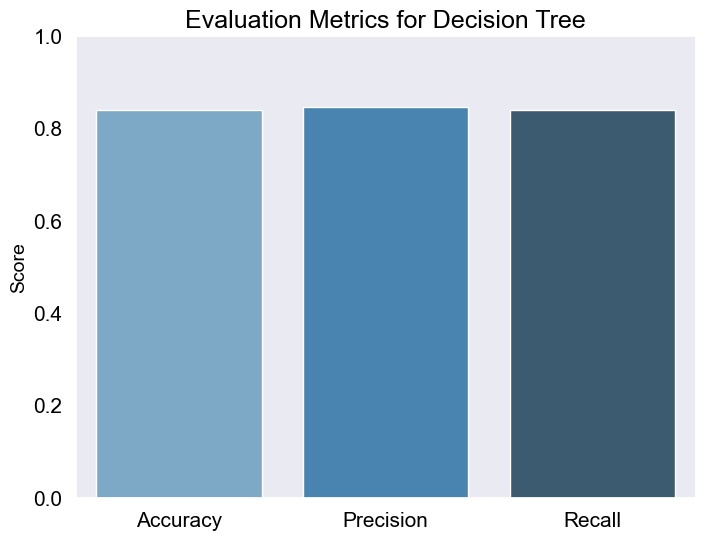

In [75]:
# Plotting the evaluation metrics (Accuracy, Precision, Recall)
metrics = ['Accuracy', 'Precision', 'Recall']
scores = [accuracy, precision, recall]

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=scores, palette='Blues_d')
plt.title('Evaluation Metrics for Decision Tree', fontsize=18)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.show()

In [77]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

# Drop the 'features' column if it exists (no axis argument)
if "features" in data.columns:
    data = data.drop("features")

# Create feature vector using VectorAssembler
assembler = VectorAssembler(inputCols=['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'Credit_History'], 
                            outputCol='features')

# Transform the data to create the feature vector
data = assembler.transform(data)

# Split the dataset into training and testing sets
trainData, testData = data.randomSplit([0.8, 0.2], seed=42)

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(labelCol="categoryIndex", featuresCol="features")

# Train the Decision Tree model
dtModel = dt.fit(trainData)

# Make predictions on the test data
predictions = dtModel.transform(testData)

# Display required columns from the predictions
predictions.select(
    'ApplicantIncome', 
    'CoapplicantIncome', 
    'Loan_Amount_Term', 
    'Credit_History',
    'rawPrediction', 
    'prediction'
).show(10)


+---------------+-----------------+----------------+--------------+-------------+----------+
|ApplicantIncome|CoapplicantIncome|Loan_Amount_Term|Credit_History|rawPrediction|prediction|
+---------------+-----------------+----------------+--------------+-------------+----------+
|            150|           1800.0|             360|             1| [275.0,32.0]|       0.0|
|           1300|           3470.0|             180|             1| [275.0,32.0]|       0.0|
|           1500|           1800.0|             360|             0|   [0.0,57.0]|       1.0|
|           1700|           2900.0|             360|             0|   [0.0,57.0]|       1.0|
|           1809|           1868.0|             360|             1| [275.0,32.0]|       0.0|
|           1836|          33837.0|             360|             1| [275.0,32.0]|       0.0|
|           1937|           1152.0|             360|             1| [275.0,32.0]|       0.0|
|           2060|           2209.0|             360|             1| [2

Accuracy: 0.8549618320610687
Precision: 0.8787180837062385
Recall: 0.8549618320610687


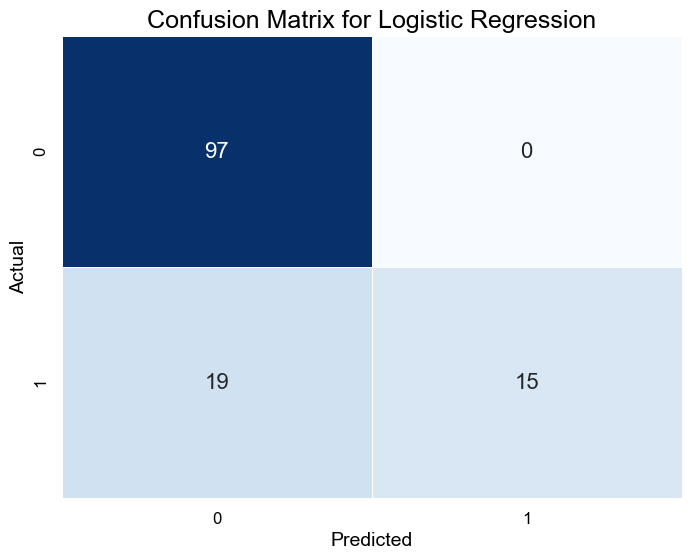

C:\Users\chetan\AppData\Local\Temp\ipykernel_46132\1705921879.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette='Blues_d')


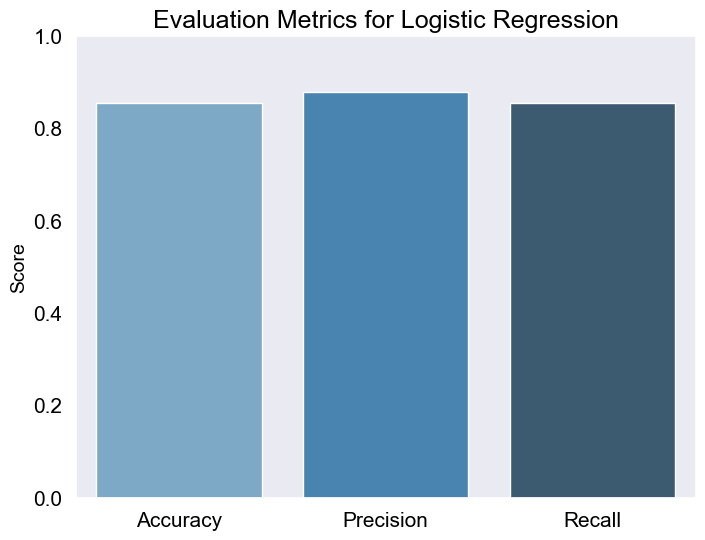

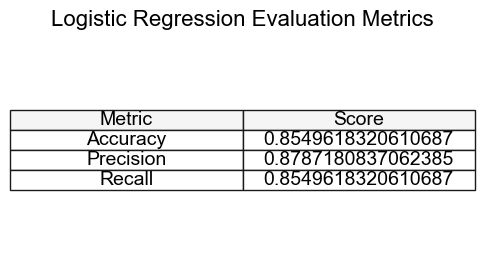

In [87]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the 'features' column if it exists (no axis argument)
if "features" in data.columns:
    data = data.drop("features")

# Create feature vector using VectorAssembler
assembler = VectorAssembler(inputCols=['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'Credit_History'], 
                            outputCol='features')

# Transform the data to create the feature vector
data = assembler.transform(data)

# Split the dataset into training and testing sets
trainData, testData = data.randomSplit([0.8, 0.2], seed=42)

# Initialize the Logistic Regression model
lr = LogisticRegression(labelCol="categoryIndex", featuresCol="features")

# Train the Logistic Regression model
lrModel = lr.fit(trainData)

# Make predictions on the test data
predictions = lrModel.transform(testData)

# Evaluate the model using MulticlassClassificationEvaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="categoryIndex", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Convert the predictions DataFrame to Pandas for confusion matrix
predictions_pd = predictions.select("categoryIndex", "prediction").toPandas()

# Confusion Matrix
conf_matrix = confusion_matrix(predictions_pd['categoryIndex'], predictions_pd['prediction'])

# Plotting Confusion Matrix with Black Color Scheme
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16}, linewidths=0.5)
plt.title('Confusion Matrix for Logistic Regression', fontsize=18)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Plotting the evaluation metrics (Accuracy, Precision, Recall)
metrics = ['Accuracy', 'Precision', 'Recall']
scores = [accuracy, precision, recall]

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=scores, palette='Blues_d')
plt.title('Evaluation Metrics for Logistic Regression', fontsize=18)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.show()

# Create a table for evaluation metrics
fig, ax = plt.subplots(figsize=(5, 3))  # Define the size of the table figure
ax.axis('off')  # Turn off the axis
table_data = [['Accuracy', accuracy], 
              ['Precision', precision], 
              ['Recall', recall]]

# Create the table
table = ax.table(cellText=table_data, colLabels=['Metric', 'Score'], loc='center', cellLoc='center', colColours=["#f5f5f5"]*2)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)  # Scale the table for better readability
plt.title('Logistic Regression Evaluation Metrics', fontsize=16)

plt.show()


In [89]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the 'features' column if it exists (no axis argument)
if "features" in data.columns:
    data = data.drop("features")

# Create feature vector using VectorAssembler
assembler = VectorAssembler(inputCols=['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'Credit_History'], 
                            outputCol='features')

# Transform the data to create the feature vector
data = assembler.transform(data)

# Split the dataset into training and testing sets
trainData, testData = data.randomSplit([0.8, 0.2], seed=42)

# Initialize the Multi-Layer Perceptron Classifier (MLP)
# Defining the layers for the MLP: input layer (4), one hidden layer (5), output layer (2)
layers = [4, 5, 2]  # 4 input features, 5 hidden units, 2 output classes

mlp = MultilayerPerceptronClassifier(labelCol="categoryIndex", featuresCol="features", maxIter=100, layers=layers)

# Train the MLP model
mlpModel = mlp.fit(trainData)

# Make predictions on the test data
predictions = mlpModel.transform(testData)

# Evaluate the model using MulticlassClassificationEvaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="categoryIndex", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Accuracy: 0.7480916030534351
Precision: 0.8120375807398708
Recall: 0.7480916030534351


In [91]:
# Load the dataset into a DataFrame
credit_data = data1.toPandas()
feature_cols = data1.columns[:-1] 
label_col = "Loan_Status"
X = credit_data[feature_cols]
y = credit_data[label_col]
data

DataFrame[Dependents: int, Education: int, Self_Employed: int, ApplicantIncome: int, CoapplicantIncome: double, LoanAmount: int, Loan_Amount_Term: int, Credit_History: int, Loan_Status: int, categoryIndex: double, features: vector]

In [93]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

indexer = StringIndexer(inputCol="Loan_Status", outputCol="categoryIndex")
indexed = indexer.fit(df).transform(df)

Accuracy: 0.7480916030534351
Precision: 0.8120375807398708
Recall: 0.7480916030534351


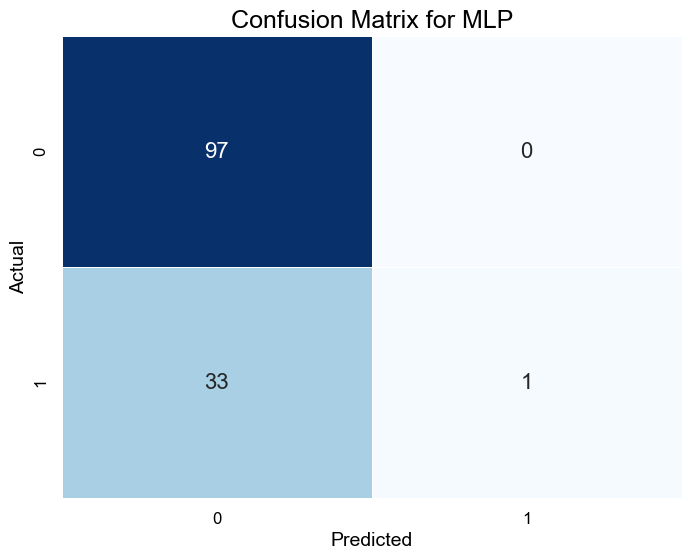

C:\Users\chetan\AppData\Local\Temp\ipykernel_46132\3334862428.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette='Blues_d')


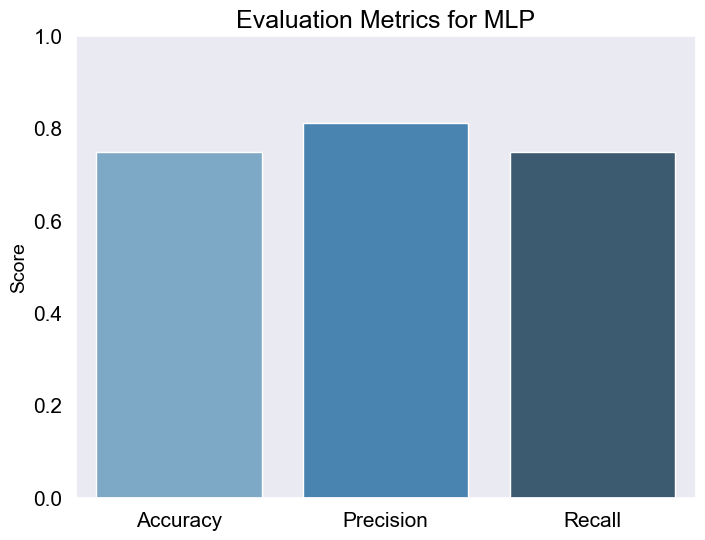

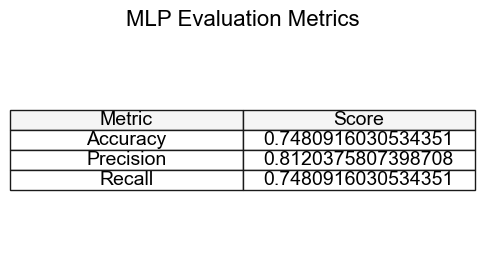

In [95]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `mlpModel` is your trained model and `testData` is the test dataset

# Make predictions using the trained model
predictions = mlpModel.transform(testData)

# Evaluate the model using MulticlassClassificationEvaluator for accuracy, precision, recall
evaluator = MulticlassClassificationEvaluator(labelCol="categoryIndex", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Convert the predictions DataFrame to Pandas for confusion matrix
predictions_pd = predictions.select("categoryIndex", "prediction").toPandas()

# Confusion Matrix
conf_matrix = confusion_matrix(predictions_pd['categoryIndex'], predictions_pd['prediction'])

# Plotting Confusion Matrix with Black Color Scheme
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16}, linewidths=0.5)
plt.title('Confusion Matrix for MLP', fontsize=18)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Plotting the evaluation metrics (Accuracy, Precision, Recall)
metrics = ['Accuracy', 'Precision', 'Recall']
scores = [accuracy, precision, recall]

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=scores, palette='Blues_d')
plt.title('Evaluation Metrics for MLP', fontsize=18)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.show()

# Create a table for evaluation metrics
fig, ax = plt.subplots(figsize=(5, 3))  # Define the size of the table figure
ax.axis('off')  # Turn off the axis
table_data = [['Accuracy', accuracy], 
              ['Precision', precision], 
              ['Recall', recall]]

# Create the table
table = ax.table(cellText=table_data, colLabels=['Metric', 'Score'], loc='center', cellLoc='center', colColours=["#f5f5f5"]*2)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)  # Scale the table for better readability
plt.title('MLP Evaluation Metrics', fontsize=16)

plt.show()


Best Model Hyperparameters: {Param(parent='MultilayerPerceptronClassifier_be6cbd2e50e8', name='blockSize', doc='block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data.'): 64, Param(parent='MultilayerPerceptronClassifier_be6cbd2e50e8', name='featuresCol', doc='features column name.'): 'features', Param(parent='MultilayerPerceptronClassifier_be6cbd2e50e8', name='labelCol', doc='label column name.'): 'categoryIndex', Param(parent='MultilayerPerceptronClassifier_be6cbd2e50e8', name='maxIter', doc='max number of iterations (>= 0).'): 50, Param(parent='MultilayerPerceptronClassifier_be6cbd2e50e8', name='predictionCol', doc='prediction column name.'): 'prediction', Param(parent='MultilayerPerceptronClassifier_be6cbd2e50e8', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability 

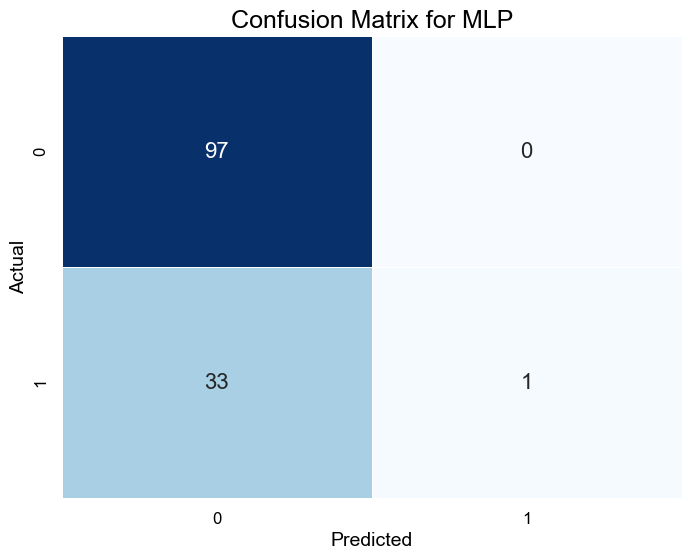

C:\Users\chetan\AppData\Local\Temp\ipykernel_46132\184457853.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette='Blues_d')


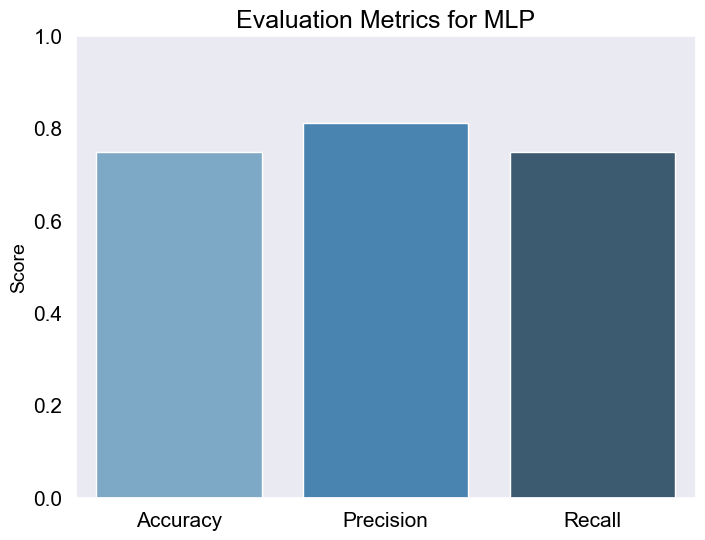

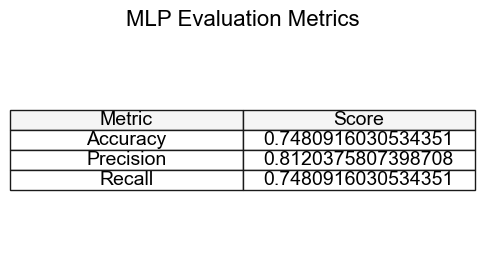

In [97]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Define the model (MLP)
mlp = MultilayerPerceptronClassifier(labelCol="categoryIndex", featuresCol="features")

# Define the parameter grid to search over
paramGrid = (ParamGridBuilder()
             .addGrid(mlp.maxIter, [50, 100])  # Test different maxIter values
             .addGrid(mlp.layers, [[4, 5, 2], [4, 8, 2]])  # Test different layers' configurations
             .addGrid(mlp.blockSize, [64, 128])  # Test different block sizes
             .addGrid(mlp.stepSize, [0.01, 0.1])  # Test different step sizes
             .build())

# Define evaluator (Accuracy for MLP classification task)
evaluator = MulticlassClassificationEvaluator(labelCol="categoryIndex", predictionCol="prediction", metricName="accuracy")

# Define CrossValidator
crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # Using 3-fold cross-validation

# Run cross-validation, and choose the best set of parameters
cvModel = crossval.fit(trainData)  # Use the training dataset

# Get the best model
bestModel = cvModel.bestModel

# Make predictions using the best model
predictions = bestModel.transform(testData)

# Evaluate the model using the best model
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the best hyperparameters and evaluation metrics
print(f"Best Model Hyperparameters: {bestModel.extractParamMap()}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Confusion Matrix
predictions_pd = predictions.select("categoryIndex", "prediction").toPandas()
conf_matrix = confusion_matrix(predictions_pd['categoryIndex'], predictions_pd['prediction'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16}, linewidths=0.5)
plt.title('Confusion Matrix for MLP', fontsize=18)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Plotting the evaluation metrics (Accuracy, Precision, Recall)
metrics = ['Accuracy', 'Precision', 'Recall']
scores = [accuracy, precision, recall]

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=scores, palette='Blues_d')
plt.title('Evaluation Metrics for MLP', fontsize=18)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.show()

# Table for evaluation metrics
fig, ax = plt.subplots(figsize=(5, 3))
ax.axis('off')
table_data = [['Accuracy', accuracy], 
              ['Precision', precision], 
              ['Recall', recall]]

table = ax.table(cellText=table_data, colLabels=['Metric', 'Score'], loc='center', cellLoc='center', colColours=["#f5f5f5"]*2)
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)
plt.title('MLP Evaluation Metrics', fontsize=16)
plt.show()


In [105]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder \
    .appName("AutoencoderBinaryClassification") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Load dataset
data = spark.read.csv("creditrisk.csv", header=True, inferSchema=True)

# Preprocessing
# Fill missing values for numerical and categorical columns
numerical_columns = [c for c in data.columns if data.select(c).dtypes[0][1] in ('int', 'double') and c != 'Loan_Status']
categorical_columns = [c for c in data.columns if c not in numerical_columns + ['Loan_Status']]

for col_name in numerical_columns:
    median_value = data.approxQuantile(col_name, [0.5], 0.01)[0]
    data = data.fillna({col_name: median_value})

for col_name in categorical_columns:
    data = data.fillna({col_name: "Unknown"})

# String indexing for categorical columns
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed") for col in categorical_columns]
for indexer in indexers:
    data = indexer.fit(data).transform(data)

# Convert target column to binary (if not already binary)
label_indexer = StringIndexer(inputCol="Loan_Status", outputCol="label").fit(data)
data = label_indexer.transform(data)

# Drop unused columns
data = data.drop(*categorical_columns, "Loan_Status")

# Assemble features
feature_columns = [col for col in data.columns if col not in ["label", "Loan_ID"]]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Scale the features
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# Train-Test Split
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Define Autoencoder (Deep Network)
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [len(feature_columns), 10, 5, 2]  # Input layer -> Hidden layers -> Output layer
autoencoder = MultilayerPerceptronClassifier(layers=layers, seed=42, featuresCol="scaledFeatures", labelCol="label", maxIter=100)

# Train the Autoencoder model
autoencoder_model = autoencoder.fit(train_data)

# Make predictions
predictions = autoencoder_model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

# Convert predictions to Pandas for detailed metrics
predictions_pd = predictions.select("label", "prediction").toPandas()

# Calculate confusion matrix, precision, recall, and accuracy
conf_matrix = confusion_matrix(predictions_pd["label"], predictions_pd["prediction"])
precision = precision_score(predictions_pd["label"], predictions_pd["prediction"])
recall = recall_score(predictions_pd["label"], predictions_pd["prediction"])
accuracy = accuracy_score(predictions_pd["label"], predictions_pd["prediction"])

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC (ROC): {auc:.2f}")




Accuracy: 0.82
Precision: 0.69
Recall: 0.50
AUC (ROC): 0.77


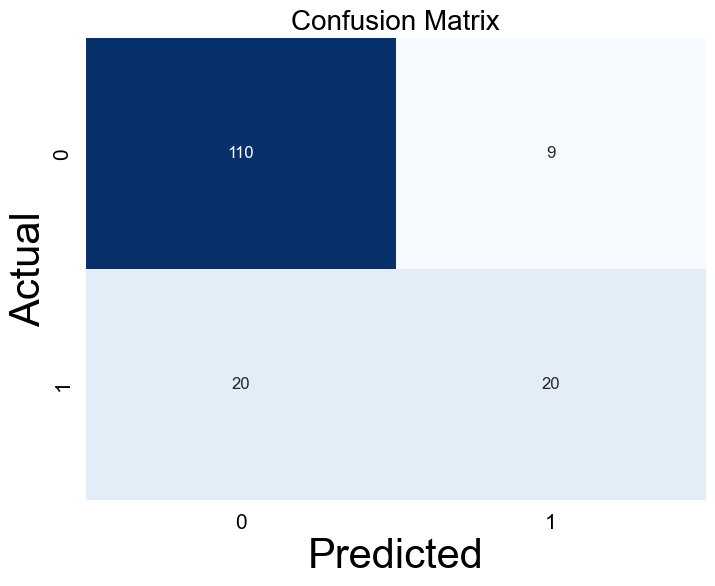

C:\Users\chetan\AppData\Local\Temp\ipykernel_46132\191728987.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="Blues_d")


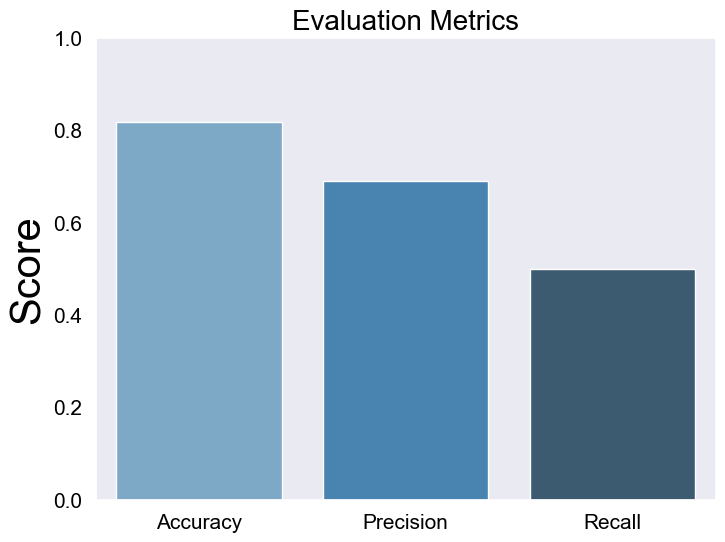

In [101]:
# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



C:\Users\chetan\AppData\Local\Temp\ipykernel_46132\696446875.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="Blues_d")


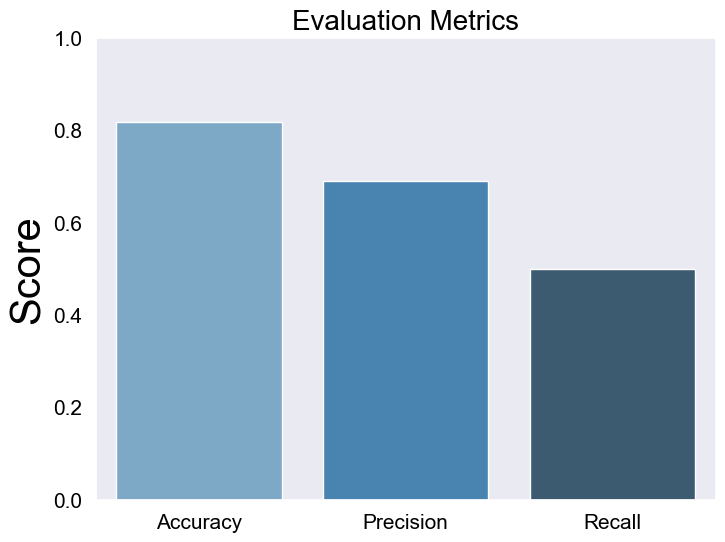

In [103]:
# Plot Evaluation Metrics (Precision, Recall, Accuracy)
metrics = ['Accuracy', 'Precision', 'Recall']
values = [accuracy, precision, recall]

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=values, palette="Blues_d")
plt.title("Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

In [6]:
pip install pymongo


   ---------------------------------------- 0.0/926.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/926.7 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.7 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.7 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.7 kB ? eta -:--:--
   --------------------- ---------------- 524.3/926.7 kB 493.7 kB/s eta 0:00:01
   --------------------- ---------------- 524.3/926.7 kB 493.7 kB/s eta 0:00:01
   --------------------- ---------------- 524.3/926.7 kB 493.7 kB/s eta 0:00:01
   -------------------------------- ----- 786.4/926.7 kB 435.8 kB/s eta 0:00:01
   -------------------------------------- 926.7/926.7 kB 478.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pyspark
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [12]:
spark = SparkSession.builder \
    .appName("NaiveBayesToMongoDB") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/your_db_name.predictions") \
    .getOrCreate()


In [18]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NaiveBayesToMongoDB") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/your_db_name.predictions") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0") \
    .getOrCreate()


In [26]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import VectorAssembler

# Initialize Spark session with MongoDB connector
spark = SparkSession.builder \
    .appName("NaiveBayesToMongoDB") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/your_db_name.predictions") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0") \
    .getOrCreate()

# Load and preprocess your data (ensure it is loaded properly)
# Assuming 'data' is your preprocessed DataFrame
assembler = VectorAssembler(inputCols=['Loan_Amount', 'Credit_History'], outputCol='features')
data = assembler.transform(data)

# Split the dataset into training and testing sets
trainData, testData = data.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the Naive Bayes model
nb = NaiveBayes(labelCol="Loan_status", featuresCol="features", modelType="multinomial")
nbModel = nb.fit(trainData)

# Make predictions on the test data
predictions = nbModel.transform(testData)

# Select required columns and display predictions (optional)
predictions.select(
    'Loan_ID',
    'Gender',
    'Property_Area',
    'Loan_Status',
    'rawPrediction',
    'prediction'
).show(10)

# Write the DataFrame to MongoDB
predictions.write.format("mongo").mode("append").save()

# Stop the Spark session
spark.stop()


IllegalArgumentException: Loan_Amount does not exist. Available: Loan_ID, Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, Property_Area, Loan_Status, Gender_Index, Married_Index, Dependents_Index, Education_Index, Self_Employed_Index, Property_Area_Index, Gender_Vec, Married_Vec, Dependents_Vec, Education_Vec, Self_Employed_Vec, Property_Area_Vec, categoryIndex, features

In [16]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Initialize the Spark session with MongoDB config
spark = SparkSession.builder \
    .appName("NaiveBayesToMongoDB") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/your_db_name.predictions") \
    .getOrCreate()

# Load the dataset (assumed to be CSV)
data = spark.read.csv('creditrisk.csv', header=True, inferSchema=True)

# Data Preprocessing
# Drop 'Loan ID' as it is not a useful feature for modeling
data = data.drop("Loan ID")

# Handle missing values by filling with the most common value (for categorical features) or mean (for numerical features)
data = data.fillna({
    'Gender': 'Male', 
    'Married': 'Married', 
    'Dependents': '0', 
    'Education': 'Graduate', 
    'Self_Employed': 'No', 
    'Credit_History': 1.0, 
    'Property_Area': 'Urban', 
    'LoanAmount': data.agg({"LoanAmount": "mean"}).collect()[0][0]
})

# Convert categorical columns to numeric using StringIndexer and OneHotEncoder
# StringIndexer for target variable
indexer = StringIndexer(inputCol="Loan_Status", outputCol="categoryIndex")

# For categorical features (Gender, Married, Dependents, Education, Self_Employed, Property_Area)
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

# Apply StringIndexer and OneHotEncoder for each categorical column
indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index") for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec") for col in categorical_columns]

# Combine all features into a single feature vector using VectorAssembler
assembler = VectorAssembler(
    inputCols=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History'] + 
               [col + "_Vec" for col in categorical_columns], 
    outputCol='features'
)

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [indexer, assembler])

# Fit the pipeline and transform the data
data = pipeline.fit(data).transform(data)

# Split the dataset into training and testing sets
trainData, testData = data.randomSplit([0.8, 0.2], seed=42)

# Initialize the Naive Bayes model
nb = NaiveBayes(labelCol="categoryIndex", featuresCol="features", modelType="multinomial")

# Train the Naive Bayes model
nbModel = nb.fit(trainData)

# Make predictions on the test data
predictions = nbModel.transform(testData)

# Display required columns from the predictions
predictions.select(
    'ApplicantIncome', 
    'CoapplicantIncome', 
    'LoanAmount', 
    'Credit_History', 
    'Gender', 
    'Married', 
    'Dependents', 
    'Education', 
    'Self_Employed', 
    'Property_Area',
    'rawPrediction', 
    'prediction'
).show(10)

# Write the DataFrame to MongoDB
predictions.write.format("mongo").mode("append").save()


+---------------+-----------------+----------+--------------+------+-------+----------+------------+-------------+-------------+--------------------+----------+
|ApplicantIncome|CoapplicantIncome|LoanAmount|Credit_History|Gender|Married|Dependents|   Education|Self_Employed|Property_Area|       rawPrediction|prediction|
+---------------+-----------------+----------+--------------+------+-------+----------+------------+-------------+-------------+--------------------+----------+
|           3000|              0.0|        66|             1|  Male|    Yes|         0|    Graduate|          Yes|        Urban|[-1140.7160429214...|       0.0|
|           2333|           1516.0|        95|             1|  Male|    Yes|         0|Not Graduate|           No|        Urban|[-3365.8687056116...|       1.0|
|           5720|              0.0|       110|             1|  Male|    Yes|         0|    Graduate|           No|        Urban|[-2071.4604029253...|       0.0|
|           2500|           1840.0

Py4JJavaError: An error occurred while calling o873.save.
: org.apache.spark.SparkClassNotFoundException: [DATA_SOURCE_NOT_FOUND] Failed to find the data source: mongo. Please find packages at `https://spark.apache.org/third-party-projects.html`.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.dataSourceNotFoundError(QueryExecutionErrors.scala:725)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:647)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSourceV2(DataSource.scala:697)
	at org.apache.spark.sql.DataFrameWriter.lookupV2Provider(DataFrameWriter.scala:873)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:260)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:251)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:103)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1570)
Caused by: java.lang.ClassNotFoundException: mongo.DefaultSource
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:592)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:525)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$5(DataSource.scala:633)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$4(DataSource.scala:633)
	at scala.util.Failure.orElse(Try.scala:224)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:633)
	... 14 more
